In [26]:
## package imports ##
import sys
sys.path.append("../../src")
from preprocessing_utils import preprocess
from utils import save_data_to_synapse, get_file_entity
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import warnings
import os
import scipy.stats as stats
from pymatch.Matcher import Matcher
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

warnings.simplefilter("ignore")
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

In [55]:
## helper functions ## 
def annot_phone(params):
    """
    Function to annotate phone types
    returns an annotated dataset with lesser choice of phonetypes
    """
    if ";" in params:
        params = params.split(";")[0]
    if ("iPhone 6+" in params) or ("iPhone 6 Plus" in params):
        return "iPhone 6+"
    if ("iPhone9" in params) or ("Unknown" in params) or ("iPad" in params) :
        return "Other iPhone"
    if ("iPhone 5" in params):
        return "iPhone 5"
    if ("iPhone8" in params):
        return "iPhone 8"
    if ("iPhone X" in params):
        return "iPhone X"
    return params


    

def show_distribution(data, target):
    """
    Function to plot several metadata information accross version 
    """
    dataV1 = data[data["version"] == "V1"]
    dataV2 = data[data["version"] == "V2"]

    fig, axes = plt.subplots(nrows = 1, ncols = 3)

    sns.distplot(dataV2["age"].dropna(), label = "V2", ax = axes[0])
    sns.distplot(dataV1["age"].dropna(), label = "V1", ax = axes[0])
    axes[0].legend()
    axes[0].set_title("Age distribution of V1 and V2")
    axes[0].grid()
    axes[0].figure.set_size_inches(15,5)

    sns.countplot(data["PD"], hue = data["version"], ax = axes[1])
    axes[1].legend()
    axes[1].set_title("PD distribution of V1 and V2")
    axes[1].grid()
    axes[1].figure.set_size_inches(15,5)
    
    sns.countplot(data["gender"], hue = data["version"], ax = axes[2])
    axes[2].legend()
    axes[2].set_title("gender distribution of V1 and V2")
    axes[2].grid()
    axes[2].figure.set_size_inches(15,5)
    

     
    
def PCA_plotter(data, feat_cols, 
                metadata_cols, target):
    
    """
    Function to implement PCA with 2 components, 
    then separate them with a target hue variable to see differences

    returns PCA-1 vs PCA-2 plots of metadata and walking features 
    separated by its groups (PD, version)
    """   
    scaler = StandardScaler()
    X_feat = data[feat_cols]
    X_metadata = data[metadata_cols]
    y = data[["version", "healthCode", "PD"]]
    
    lr = LogisticRegression(random_state = 100)
    gb = GradientBoostingClassifier(random_state = 100)
    X_train, X_test, y_train, y_test = train_test_split(X_feat, y[target],
                                                        test_size = 0.2,
                                                        random_state = 100)
    
    gb.fit(X_train, y_train)
    
    print(classification_report(gb.predict(X_test), y_test))
    
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_feat)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[0])
    axes[0].set_title("PCA plot on Walking Features")
    axes[0].set_ylabel("PC2")
    axes[0].set_xlabel("PC1")
    axes[0].grid()
    
    
    #Plotting the Cumulative Summation of the Explained Variance
    X_scaled = scaler.fit_transform(X_metadata)
    pca = PCA().fit(X_scaled)
    pca = PCA(n_components = 3)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    
    sns.scatterplot(principal_df[0], principal_df[1], 
                    hue = principal_df[target], ax = axes[1])
    axes[1].set_title("PCA plot on metadata")
    axes[1].set_ylabel("PC2")
    axes[1].set_xlabel("PC1")
    axes[1].grid()
    
    plt.show()
    

def OHE_data(data):
    """
    Function to one-hot encode the metadata
    it will encode factorial and categorical variables (phonetype, gender and versions)
    returns the encoded dataset, and the result of the encoded columns
    """
    metadata_df = data
    metadata_cols = [feat for feat in metadata_df.columns if ("." not in feat) and ("healthCode" not in feat)]
    # metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"])], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["phone_type"], 
                                                         prefix = "OHE_is")], axis = 1) 
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["gender"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    metadata_df = pd.concat([metadata_df, pd.get_dummies(metadata_df["version"], 
                                                         drop_first = True, 
                                                         prefix = "OHE_is")], axis = 1)
    OHE_meta_cols = [feat for feat in metadata_df.columns if ("OHE" in feat) or ("age" in feat) or ("PD" in feat)]
    return metadata_df, OHE_meta_cols




def balance_hc(data, matching_columns):
    
    """
    Function to create paired healthcodes
    takes in a dataset of PDKIT features

    matching methods:
    Join version 1 and version 2 table by leveraging phone types and gender
    Iterate through each healthcode pairs, and prioritize healthcode pairs that have smaller age differences

    Note: Not joining by PD status due to the non-PD data being discarded significantly

    """
    
    
    ref = pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")
    list_of_spans = ref.loc[(ref["V1"] > 0) & (ref["V2"] > 0)].index
    data = data[data["phone_type"].isin(list_of_spans)].reset_index(drop = True)
    
    
    hcx_used = []
    hcy_used = []

    V1 = data[data["version"] == "V1"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    V2 = data[data["version"] == "V2"][["healthCode", "version", "phone_type", "gender", "PD", "age"]]
    tst_data = pd.merge(V1, V2, on = matching_columns, how = "inner")
    tst_data["age_diff"] = np.abs(tst_data["age_x"] - tst_data["age_y"])
    tst_data = tst_data.sort_values("age_diff").reset_index(drop = True)


    for hc_x, hc_y in zip(tst_data["healthCode_x"], tst_data["healthCode_y"]):

        if (hc_y not in hcy_used) and (hc_x not in hcx_used):
            hcy_used.append(hc_y)
            hcx_used.append(hc_x)

    lst = hcx_used + hcy_used
    return data[data["healthCode"].isin(lst)]



def getKNN_user2user(data, no_neighbors, 
                     distance_metrics, 
                     cols_used):
    
    """
    a function to get K-Nearest Neighbor from user in version 1 to version 2

    ##  pseudocode  ##
    for each healthcode in user 1, find K other pair that is similar in "insert here" similarity metrics
    afterwards, filter the data to only pair the healthcode in version 1 to those in version 2
    then collect all the unique healthcodes that is left after the filter
    """
    data_v1 = data[data["version"] == "V1"]
    data_v2 = data[data["version"] == "V2"]
    data = data.set_index("healthCode")
    min_max_scaler = MinMaxScaler()
    walking_features = min_max_scaler.fit_transform(data[cols_used])
    nbrs = NearestNeighbors(n_neighbors = no_neighbors, 
                            algorithm = 'auto', 
                            metric = distance_metrics).fit(walking_features)
    distance, indices = nbrs.kneighbors(walking_features)
    _dict = {}
    _dict["healthCode_ref"] = []
    _dict["healthCode_pair"] = []
    _dict["distance"] = []
    data = data.reset_index()
    for dist, indice in zip(distance, indices):
        for healthcode_idx, _dist in zip(indice[1:], dist[1:]):
            _dict["healthCode_ref"].append(data.ix[indice[0]]["healthCode"])
            _dict["distance"].append(_dist)
            _dict["healthCode_pair"].append(data.ix[healthcode_idx]["healthCode"])
    matches = pd.DataFrame(_dict).sort_values(by = "distance", ascending = False)
    v2_list = data[data["version"] == "V2"]["healthCode"].unique()
    matches = matches[(~matches["healthCode_ref"].isin(v2_list)) \
        & (matches["healthCode_pair"].isin(v2_list))]
    matched_data = data[(data["healthCode"].isin(matches["healthCode_ref"].unique())) \
                | (data["healthCode"].isin(matches["healthCode_pair"].unique()))].reset_index(drop = True)
    return matched_data


def QaD_correlation(values, classes, isFactor=None):
    """Given a set of values or class assignments determines correlation/enrichment 
    in list of classificiations.
    Uses, correlation or fisher tests
    
    Arguments:
    - `values`:  Vector of values (either numeric or factors)
    - `classes`:  a two dimensional array or pandas DataFrame of (either numeric or factors)
    - `isFactor`: list of same length as classes of T/F indicating weather each 
                  class is a factor or continuous variable (defaults to None) meaning
                  strings are used factors and numbers as continuous
    Returns a list of p-values one for each classification in classes
    """

    isFactor = [None]*len(classes) if isFactor==None else isFactor
    pVals = []
    classes = pd.DataFrame(classes)
    for i, key in enumerate(classes):
        classification = classes[key]
        #If it is a factor perform ANOVA across groups
        if ((classification.dtype in [np.string_,  np.object_, np.bool_, np.unicode_]) or 
            isFactor[i]):
            groupLabels = list(set(classification.dropna()))
            groups = [values[np.where(classification==l)] for l in groupLabels]
            f_val, p_val = stats.f_oneway(*groups) 
            #if np.isnan(p_val):
            #    print groupLabels
            pVals.append(p_val)
            #print list(set(classification)), p_val
        #If it is not a factor perform correlation analysis
        else:
            m, b, r_val, p_val, slope_std_error = stats.linregress(values, classification)
            pVals.append(p_val)
    pVals = np.asarray(pVals)
    pVals[np.isnan(pVals)] = np.inf
    series = pd.Series(data = pVals, index = classes.columns)
    return series

# Introduction:

This notebook will explore preliminary techniques to reduce confounding factors of the metadata. 
- Age distribution of the version 2 and passive data will be set to have the lowest limit of the minimum age in version one, to sustain the same age distribution accross versions
- Age distribution, gender, and PD distribution accross version will be compared to see if there are any imbalances
- PCA plots of version vs walking features and version vs meteadata of first and second principal component will be plotted
- One-way ANOVA analysis of metadata association to another metadata in terms of p-value to analyze whether there are still associations

In [44]:
## retrieve datasets ##


### retrieve version 1 data ###
dataV1 = get_file_entity("syn21248673")


### retrieve data from mPower version 2 ###
### side note: some data are prune to match the distribution to those in V1 ###
dataV2 = get_file_entity("syn21248675")
dataV2 = dataV2[dataV2["age"] >= dataV1["age"].min()]

### retrieve passive data ####
dataPassive = get_file_entity("syn21248676")


## concatenate dataset and annotate iphone type ## 
data = pd.concat([dataV1, dataV2]).reset_index().dropna()
data["phone_type"] = data["phoneInfo"].apply(annot_phone)

# Type of phones that span accross versions 

In [45]:
pd.pivot_table(data = data, index = "phone_type", columns = "version", values = "PD", aggfunc = "count")

version,V1,V2
phone_type,,
Other iPhone,2.0,21.0
iPhone 5,47.0,8.0
iPhone 6,90.0,39.0
iPhone 6+,49.0,12.0
iPhone 6S,NaN,26.0
iPhone 6S+,NaN,12.0
iPhone 7,NaN,38.0
iPhone 7+,NaN,25.0
iPhone 8,4.0,33.0


From the tabular dataframe above, we can see that there are only several phones that spans accross the two versions.

## 1.) Pre-matching Dataset (default)

In [46]:
## get encoded data
encoded_data = OHE_data(data)[0]

## column feature lists
walking_feat_cols = [feat for feat in data.columns if "." in feat]
metadata_feat_cols = [feat for feat in data.columns if ("." not in feat) and ("healthCode" not in feat)]
OHE_feat_cols = OHE_data(data)[1]

              precision    recall  f1-score   support

          V1       0.86      0.84      0.85        43
          V2       0.86      0.88      0.87        50

    accuracy                           0.86        93
   macro avg       0.86      0.86      0.86        93
weighted avg       0.86      0.86      0.86        93



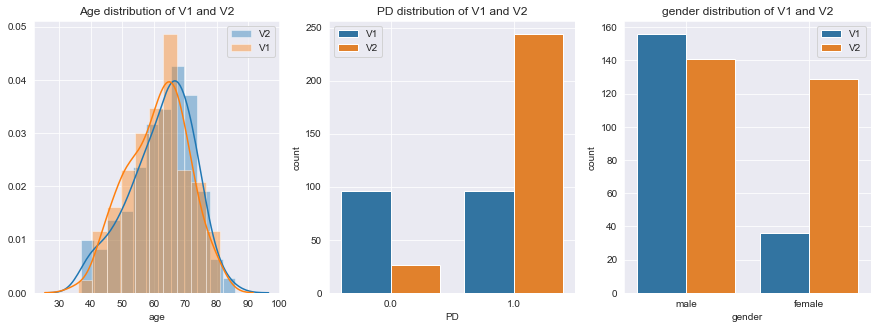

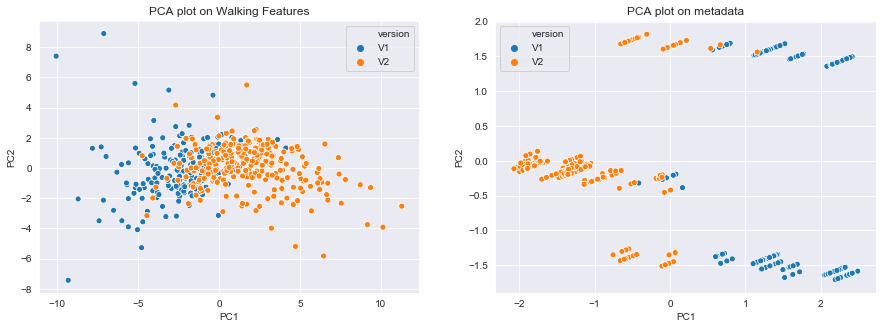

              precision    recall  f1-score   support

         0.0       0.39      0.38      0.38        24
         1.0       0.79      0.80      0.79        69

    accuracy                           0.69        93
   macro avg       0.59      0.59      0.59        93
weighted avg       0.68      0.69      0.69        93



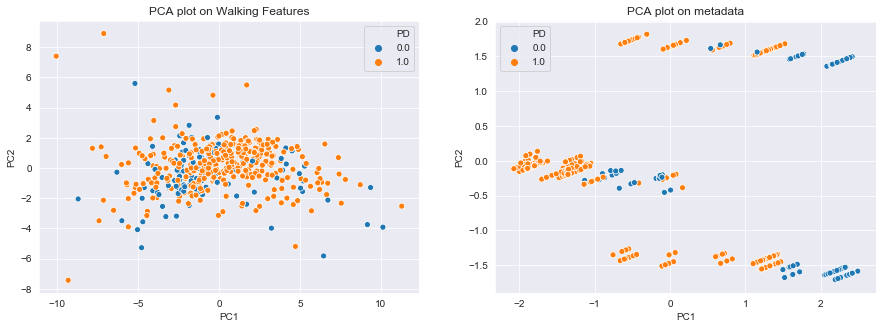

In [137]:
show_distribution(encoded_data[metadata_feat_cols], "version")
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(encoded_data, walking_feat_cols, OHE_feat_cols, "PD")

The prematching plot shows that there are a very large separation accross the versions, which means that there might be some signals on the metadata. As seen from how a simple GradientBoosting can classify the versions, it is imperative to subsample our dataset so that our metadata will confound the predictive capability of the walking features that will be implemented.

## 2.) Matched Dataset by Phone Types and Gender

              precision    recall  f1-score   support

          V1       0.80      0.75      0.77        16
          V2       0.64      0.70      0.67        10

    accuracy                           0.73        26
   macro avg       0.72      0.72      0.72        26
weighted avg       0.74      0.73      0.73        26



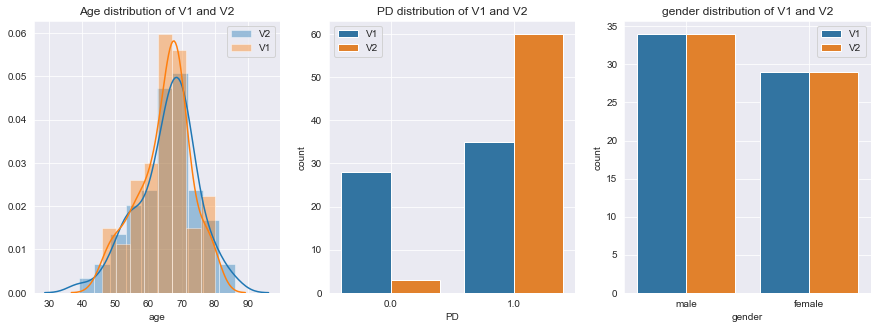

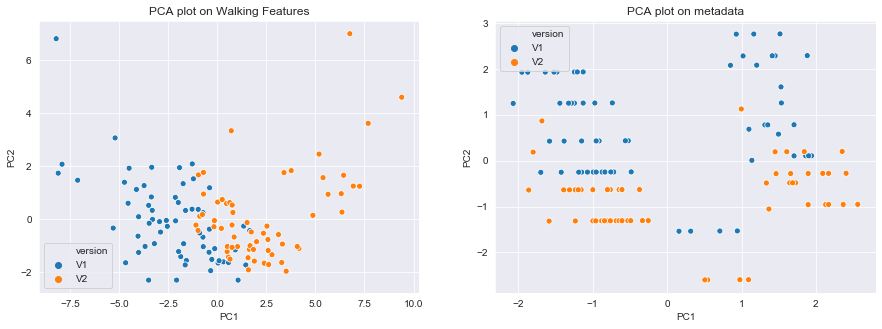

              precision    recall  f1-score   support

         0.0       0.25      0.33      0.29         6
         1.0       0.78      0.70      0.74        20

    accuracy                           0.62        26
   macro avg       0.51      0.52      0.51        26
weighted avg       0.66      0.62      0.63        26



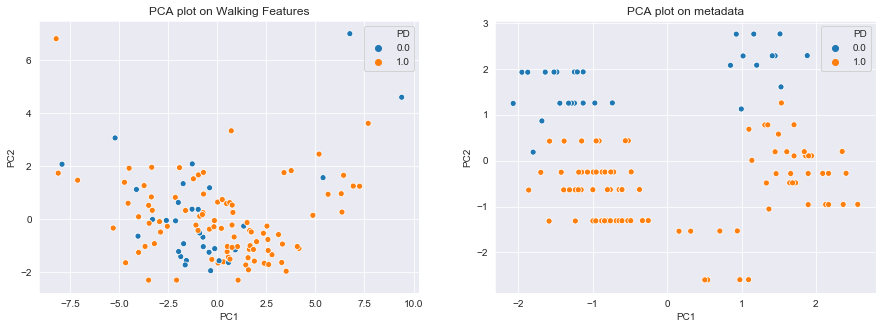

In [136]:
balance_hc_data = balance_hc(encoded_data, ["phone_type", "gender"]).reset_index(drop = True)
show_distribution(balance_hc_data[metadata_feat_cols], "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "PD")

By matching using spanning phone types, gender, and closest age differences, we can see that PCs are more evenly spread accross version 1 and version 2, however still slightly separable as most of the version 1 is on the upper area of the plot. In terms of its walking features, it is apparent that version 1 and version 2 is still linearly separable from each other. 

The reason why most of the V1s are lying on top is due to the uneven distribution of non-PD in our data collections, especially as most of the V1 has far more Non-PD data.

## 3.) Matched Dataset by Phone Types, Gender, and PD

              precision    recall  f1-score   support

          V1       1.00      0.71      0.83        14
          V2       0.67      1.00      0.80         8

    accuracy                           0.82        22
   macro avg       0.83      0.86      0.82        22
weighted avg       0.88      0.82      0.82        22



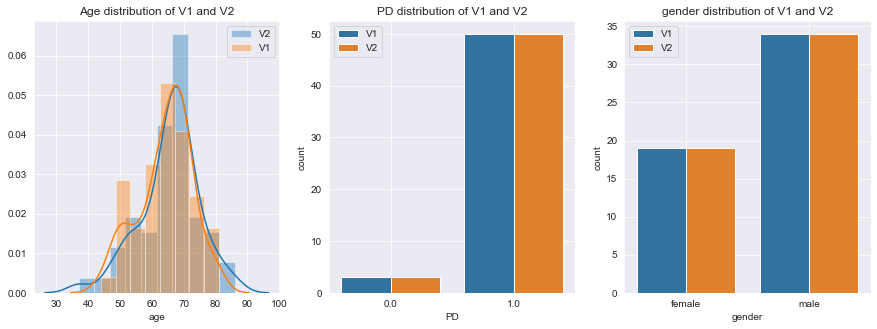

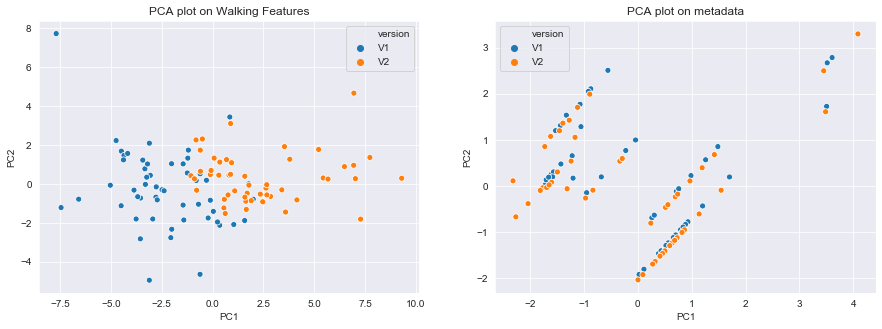

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.82      0.90        22

    accuracy                           0.82        22
   macro avg       0.50      0.41      0.45        22
weighted avg       1.00      0.82      0.90        22



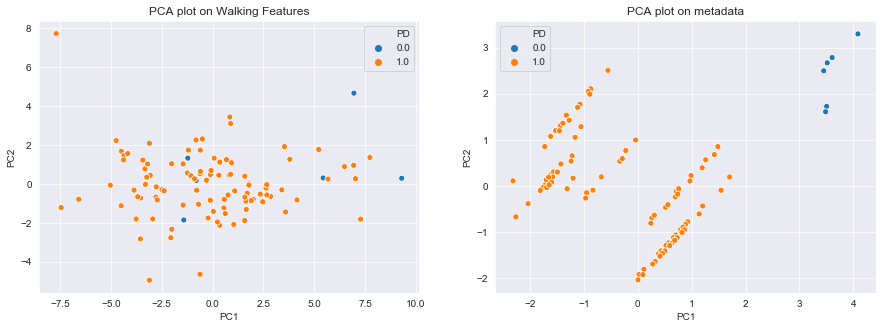

In [138]:
balance_hc_data = balance_hc(encoded_data, ["phone_type", "PD", "gender"]).reset_index(drop = True)
show_distribution(balance_hc_data[metadata_feat_cols], "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "version")
PCA_plotter(balance_hc_data, walking_feat_cols, OHE_feat_cols, "PD")

## 4.) Use Similarity Metrics to Convolute and Prune the healthCodes

In [131]:
matched_data = getKNN_user2user(data, 5, "euclidean", walking_feat_cols)
matched_data_encoded = OHE_data(matched_data)[0]

              precision    recall  f1-score   support

          V1       0.94      0.89      0.91        18
          V2       0.88      0.93      0.90        15

    accuracy                           0.91        33
   macro avg       0.91      0.91      0.91        33
weighted avg       0.91      0.91      0.91        33



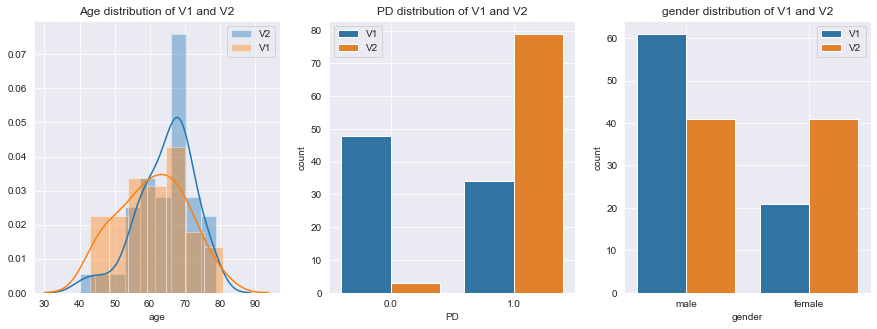

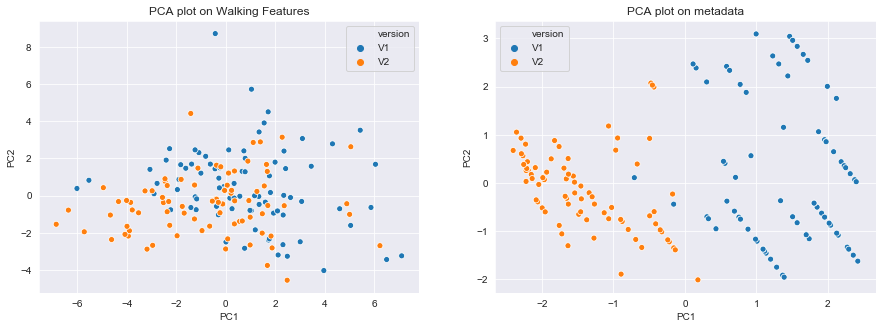

In [132]:
show_distribution(matched_data_encoded, "version")
PCA_plotter(matched_data_encoded, walking_feat_cols, OHE_feat_cols, "version")

The graph above shows that by pruning based on similarities, we are able to convolute the separation between the features, additionally, we can see that our logistic regression prediction performance was not as good as the ones before the healthcode pruning. 

# Metadata Association Analysis

This section will see whether eath metadata still has some association towards other metadatas, we will test the groupings of whether the subject is_male, is_v2, is_PD 
against all other metadata. The ideal case is to have large p-value, meaning that the metadata association is almost nonexistent to all the other metadata.

## One-Way Anova Association on Metadata

In [82]:
def print_pvals_ftest(data, group):
    metadata_df = OHE_data(data)[0]
    OHE_cols = OHE_data(data)[1]
    return QaD_correlation(metadata_df[group], metadata_df[OHE_cols])

## 1.) Before Matching

In [84]:
print("### Gender ####")
print_pvals_ftest(data, "OHE_is_male")

### Gender ####


PD                     3.507287e-02
age                    5.888482e-01
OHE_is_Other iPhone    5.887126e-01
OHE_is_iPhone 5        9.104805e-02
OHE_is_iPhone 6        2.929322e-02
OHE_is_iPhone 6+       5.177663e-02
OHE_is_iPhone 6S       4.603562e-03
OHE_is_iPhone 6S+      6.636386e-01
OHE_is_iPhone 7        5.522595e-02
OHE_is_iPhone 7+       6.464965e-01
OHE_is_iPhone 8        8.725807e-02
OHE_is_iPhone 8+       2.582403e-01
OHE_is_iPhone SE       8.452939e-01
OHE_is_iPhone X        1.653578e-01
OHE_is_male            0.000000e+00
OHE_is_V2              5.761123e-11
dtype: float64

In [90]:
print("### age ###")
print_pvals_ftest(data, "age")

### age ###


PD                     0.000016
age                    0.000000
OHE_is_Other iPhone    0.936575
OHE_is_iPhone 5        0.061201
OHE_is_iPhone 6        0.822707
OHE_is_iPhone 6+       0.446523
OHE_is_iPhone 6S       0.204383
OHE_is_iPhone 6S+      0.913351
OHE_is_iPhone 7        0.714456
OHE_is_iPhone 7+       0.370863
OHE_is_iPhone 8        0.591144
OHE_is_iPhone 8+       0.288788
OHE_is_iPhone SE       0.525513
OHE_is_iPhone X        0.181863
OHE_is_male            0.588848
OHE_is_V2              0.177219
dtype: float64

In [94]:
## association in version groupings
print("### version ###")
print_pvals_ftest(data, "OHE_is_V2")

### version ###


PD                     1.452801e-24
age                    1.772191e-01
OHE_is_Other iPhone    9.979073e-04
OHE_is_iPhone 5        5.247305e-13
OHE_is_iPhone 6        2.847182e-15
OHE_is_iPhone 6+       1.579971e-11
OHE_is_iPhone 6S       8.114388e-06
OHE_is_iPhone 6S+      3.016968e-03
OHE_is_iPhone 7        3.778924e-08
OHE_is_iPhone 7+       1.250852e-05
OHE_is_iPhone 8        6.886087e-05
OHE_is_iPhone 8+       1.311475e-03
OHE_is_iPhone SE       8.642419e-04
OHE_is_iPhone X        5.253178e-06
OHE_is_male            5.761123e-11
OHE_is_V2              0.000000e+00
dtype: float64

In [96]:
## association in duration groupings
print("### PD ###")
print_pvals_ftest(data, "PD")

### PD ###


PD                     0.000000e+00
age                    1.640111e-05
OHE_is_Other iPhone    6.033393e-01
OHE_is_iPhone 5        5.670266e-03
OHE_is_iPhone 6        1.006944e-03
OHE_is_iPhone 6+       1.951822e-04
OHE_is_iPhone 6S       7.697141e-02
OHE_is_iPhone 6S+      3.556250e-02
OHE_is_iPhone 7        1.217171e-01
OHE_is_iPhone 7+       9.331741e-02
OHE_is_iPhone 8        2.460060e-03
OHE_is_iPhone 8+       2.282735e-02
OHE_is_iPhone SE       1.830778e-02
OHE_is_iPhone X        1.597752e-01
OHE_is_male            3.507287e-02
OHE_is_V2              1.452801e-24
dtype: float64

## 2.) After Phone Type, Gender Matching

In [103]:
balance_hc_data = balance_hc(data, ["phone_type", "gender"]).reset_index(drop = True)

In [104]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                     0.123574
age                    0.283135
OHE_is_Other iPhone    0.872710
OHE_is_iPhone 5        0.735724
OHE_is_iPhone 6        0.981793
OHE_is_iPhone 6+       0.181786
OHE_is_iPhone 8        0.006682
OHE_is_male            0.000000
OHE_is_V2              1.000000
dtype: float64

In [105]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                     0.248897
age                    0.000000
OHE_is_Other iPhone    0.729478
OHE_is_iPhone 5        0.083035
OHE_is_iPhone 6        0.059106
OHE_is_iPhone 6+       0.043031
OHE_is_iPhone 8        0.038730
OHE_is_male            0.283135
OHE_is_V2              0.590256
dtype: float64

In [106]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_V2")

### version ###


PD                     5.700909e-08
age                    5.902564e-01
OHE_is_Other iPhone    1.000000e+00
OHE_is_iPhone 5        1.000000e+00
OHE_is_iPhone 6        1.000000e+00
OHE_is_iPhone 6+       1.000000e+00
OHE_is_iPhone 8        1.000000e+00
OHE_is_male            1.000000e+00
OHE_is_V2              0.000000e+00
dtype: float64

In [107]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                     0.000000e+00
age                    2.488966e-01
OHE_is_Other iPhone    9.852080e-01
OHE_is_iPhone 5        2.029078e-01
OHE_is_iPhone 6        7.412523e-01
OHE_is_iPhone 6+       6.368913e-01
OHE_is_iPhone 8        9.647185e-02
OHE_is_male            1.235741e-01
OHE_is_V2              5.700909e-08
dtype: float64

## 3.) By Phone Type, Gender, PD Matching

In [108]:
balance_hc_data = balance_hc(data, ["phone_type", "gender", "PD"]).reset_index(drop = True)

In [109]:
print("### gender ###")
print_pvals_ftest(balance_hc_data, "OHE_is_male")

### gender ###


PD                     0.107073
age                    0.097631
OHE_is_Other iPhone    0.551841
OHE_is_iPhone 5        0.203829
OHE_is_iPhone 6        0.541813
OHE_is_iPhone 6+       0.408773
OHE_is_iPhone 8        0.027925
OHE_is_male            0.000000
OHE_is_V2              1.000000
dtype: float64

In [110]:
print("### age ###")
print_pvals_ftest(balance_hc_data, "age")

### age ###


PD                     1.687833e-07
age                    0.000000e+00
OHE_is_Other iPhone    6.349155e-01
OHE_is_iPhone 5        1.675172e-01
OHE_is_iPhone 6        3.817378e-01
OHE_is_iPhone 6+       3.615727e-01
OHE_is_iPhone 8        6.061523e-02
OHE_is_male            9.763134e-02
OHE_is_V2              4.669535e-01
dtype: float64

In [111]:
print("### version ###")
print_pvals_ftest(balance_hc_data, "OHE_is_V2")

### version ###


PD                     1.000000
age                    0.466954
OHE_is_Other iPhone    1.000000
OHE_is_iPhone 5        1.000000
OHE_is_iPhone 6        1.000000
OHE_is_iPhone 6+       1.000000
OHE_is_iPhone 8        1.000000
OHE_is_male            1.000000
OHE_is_V2              0.000000
dtype: float64

In [112]:
print("### PD ###")
print_pvals_ftest(balance_hc_data, "PD")

### PD ###


PD                     0.000000e+00
age                    1.687833e-07
OHE_is_Other iPhone    6.214610e-01
OHE_is_iPhone 5        2.920933e-01
OHE_is_iPhone 6        2.726217e-02
OHE_is_iPhone 6+       2.582512e-01
OHE_is_iPhone 8        4.759229e-01
OHE_is_male            1.070730e-01
OHE_is_V2              1.000000e+00
dtype: float64

## 4.) By Feature Similarity Distance Metrics

In [76]:
similarity_matched_data = matched_data

In [113]:
print("### gender ###")
print_pvals_ftest(similarity_matched_data, "OHE_is_male")

### gender ###


PD                     0.028943
age                    0.441860
OHE_is_Other iPhone    0.407463
OHE_is_iPhone 5        0.536615
OHE_is_iPhone 6        0.034521
OHE_is_iPhone 6+       0.536615
OHE_is_iPhone 6S       0.533151
OHE_is_iPhone 6S+      0.613173
OHE_is_iPhone 7        0.141411
OHE_is_iPhone 7+       0.261356
OHE_is_iPhone 8        0.066565
OHE_is_iPhone 8+       0.261356
OHE_is_iPhone SE       0.301020
OHE_is_iPhone X        0.595524
OHE_is_male            0.000000
OHE_is_V2              0.001160
dtype: float64

In [114]:
print("### age ###")
print_pvals_ftest(similarity_matched_data, "age")

### age ###


PD                     0.003717
age                    0.000000
OHE_is_Other iPhone    0.978986
OHE_is_iPhone 5        0.005222
OHE_is_iPhone 6        0.254037
OHE_is_iPhone 6+       0.070930
OHE_is_iPhone 6S       0.305544
OHE_is_iPhone 6S+      0.628933
OHE_is_iPhone 7        0.164898
OHE_is_iPhone 7+       0.784860
OHE_is_iPhone 8        0.556689
OHE_is_iPhone 8+       0.543969
OHE_is_iPhone SE       0.856161
OHE_is_iPhone X        0.253502
OHE_is_male            0.441860
OHE_is_V2              0.007373
dtype: float64

In [115]:
print("### version ###")
print_pvals_ftest(similarity_matched_data, "OHE_is_V2")

### version ###


PD                     6.167505e-17
age                    7.372513e-03
OHE_is_Other iPhone    1.750983e-01
OHE_is_iPhone 5        2.024174e-04
OHE_is_iPhone 6        6.903428e-06
OHE_is_iPhone 6+       1.216866e-03
OHE_is_iPhone 6S       1.240191e-02
OHE_is_iPhone 6S+      4.316643e-02
OHE_is_iPhone 7        3.547331e-03
OHE_is_iPhone 7+       1.882332e-03
OHE_is_iPhone 8        1.348327e-03
OHE_is_iPhone 8+       1.882332e-03
OHE_is_iPhone SE       8.134928e-02
OHE_is_iPhone X        4.316643e-02
OHE_is_male            1.160221e-03
OHE_is_V2              0.000000e+00
dtype: float64

In [116]:
print("### PD ###")
print_pvals_ftest(similarity_matched_data, "PD")

### PD ###


PD                     0.000000e+00
age                    3.717482e-03
OHE_is_Other iPhone    1.286632e-01
OHE_is_iPhone 5        1.047971e-02
OHE_is_iPhone 6        1.032104e-01
OHE_is_iPhone 6+       2.145862e-03
OHE_is_iPhone 6S       9.473761e-02
OHE_is_iPhone 6S+      1.758199e-01
OHE_is_iPhone 7        2.466037e-01
OHE_is_iPhone 7+       5.568939e-01
OHE_is_iPhone 8        1.140876e-02
OHE_is_iPhone 8+       3.836467e-02
OHE_is_iPhone SE       2.428558e-01
OHE_is_iPhone X        1.758199e-01
OHE_is_male            2.894273e-02
OHE_is_V2              6.167505e-17
dtype: float64

Looking at the p-values of the one-way ANOVA tests, it is apparent that phone types, gender and PD matching resulted in the best subsamples that diminishes association accross the metadatas. However, this method diminishes the number of NON-PD by a significant amount, which will cause detrimental effects towards our predictive model as it will not have enough non-PD feature data. 

In [119]:
encoded_data[[feat for feat in encoded_data.columns if "." in feat]].columns

Index(['MAX_x.gait_step_regularity', 'MAX_x.gait_symmetry',
       'MAX_x.max_freeze_index', 'MAX_x.speed_of_gait',
       'MAX_y.gait_step_regularity', 'MAX_y.gait_symmetry',
       'MAX_y.max_freeze_index', 'MAX_y.speed_of_gait',
       'MAX_z.gait_step_regularity', 'MAX_z.gait_symmetry',
       'MAX_z.max_freeze_index', 'MAX_z.speed_of_gait',
       'MAX_AA.gait_step_regularity', 'MAX_AA.gait_symmetry',
       'MAX_AA.max_freeze_index', 'MAX_AA.speed_of_gait',
       'MAX_FC.speed_of_gait', 'MAX_FC.no_of_steps_per_sec',
       'MAX_x.freeze_occurences_per_sec', 'MAX_y.freeze_occurences_per_sec',
       'MAX_z.freeze_occurences_per_sec', 'MAX_AA.freeze_occurences_per_sec',
       'MAX_x.frequency_of_peaks_log', 'MAX_y.frequency_of_peaks_log',
       'MAX_z.frequency_of_peaks_log', 'MAX_AA.frequency_of_peaks_log'],
      dtype='object')

In [123]:
encoded_data["duration"][encoded_data["version"] == "V1"].mean()

28.538090960937506

In [124]:
encoded_data["duration"][encoded_data["version"] == "V2"].mean()

31.25513974072222